<a href="https://colab.research.google.com/github/barauna-lo/CAP4213-Deep-Learning/blob/main/AT10_Recurrent_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src=https://raw.githubusercontent.com/barauna-lo/CAP4213-Deep-Learning/main/logoinpe.png>


# CAP-421-3: Aprendizado Profundo
## Atividade 10

* Luan Orion Baraúna 

# Recurrent Neural Networks (RNNs)

## Recursion
---

In computer science, recursion is a method of solving a problem where the solution depends on solutions to smaller instances of the same problem [graham1990].

> *Example:* I believe that 12 + 12 is 4!

> ...

> *I believe that 12 + 12 is* $4\color{red}{!}$

$
\begin{align}
4! & = 4 \times 3 \times 2 \times 1 \\
  & = (4 \times 3) \times (2 \times 1) \\
  & = 12 \times 2 \\
  & = 24 \\
  12 + 12 & = 24
\end{align}
$

We can rewrite the previous equations as:

$
\begin{align}
24 & = 4 \times 3 \times 2 \times 1\\
  & = 4 \times 3 \times 2! \\
  & = 4 \times 3! \\
  & = 4! 
\end{align}
$

### Exercise 1

Implement, using recursion, the function `f(n)`, to compute the **factorial** of a number $n$, given that:

$
\text{f}(n) = \Big \{
\begin{align}
1, & ~ \text{if} ~ n = 0 \\
n \times \text{f}(n-1), & ~ \text{if} ~ n > 0
\end{align}
$


In [1]:
def f(n):
  print(f'f({n}) = ', end='')
  
  if n == 0:
    print(1)
    return 1
  
  print(f'{n} * f({n-1})')
  return n * f(n-1)

print(f(4))

f(4) = 4 * f(3)
f(3) = 3 * f(2)
f(2) = 2 * f(1)
f(1) = 1 * f(0)
f(0) = 1
24


## Sequence Labelling
---

> *This section is based on [graves2012].*

Exemples of sequences include speech and handwriting recognition. Supervised sequence labelling refers specifically to those cases where a set of hand-transcribed sequences is provided for algorithm training. Individual points cannot be assumed to be independent. Inputs and the labels form strongly correlated sequences.

The goal of sequence labelling is to assign sequences of labels, drawn from a fixed alphabet, to sequences of input data:
* acoustic features with spoken words
* video frames with hand gestures
* protein secondary strucuture prediction (not time series)

Sequence modelling is not appropriate when:
* the number of input neurons to be used *a priori* is unknown
* *the sequence order matters*: when the parameters in a model are not shared, inverting the order of the input can lead to wrong results

Assuming that each target sequence is at most as long as the corresponding input sequence, let $S$ be a set of training examples drawn independently from a fixed distribution $D_{x \times y}$. The input space $X$ is the set of all sequences of size $M$ vectors. The target space $Y$ is the set of all sequences over the alphabet of $L$ labels. The elements of $L$ are *label sequences*. 

Each element of $S$ is a pair of sequences $(x, y)$, where the target sequence $y = (y_1, y_2, \dots, y_U)$ is at most as long as the input sequence $x = (x_1, x_2, \dots, x_\tau)$. The distinct points in the input sequence are referred to as *timesteps*. The task is to use $S$ to train a sequence labelling algorithm $h: X \rightarrow Y$ to label the sequences in a test set $S'$ as accurately as possible.

We can think of three classes of sequence labelling, depending on the input and label sequences:

* in **sequence classification**, a key feature is that the *entire sequence* can be processed before the classification is made. The error measure can be the percentage of misclassifications (the *sequence error rate*):
$E^{\text{seq}} (h, S') = \frac{100}{|S'|} \sum_{(x,y)\in S'} \Big\{ 
\begin{align}
0& ~ \text{if} ~ h(x) = y \\
1& ~ \text{otherwise}
\end{align}$, where $|S'|$ is the number of elements in $S'$.

* in **segment classification**, the target sequences have multiple labels, but the locations of the labels are known in advance (such as natural language processing or bioinformatics). The crucial element is the use of *context information*, and the error measure counts the percentage of misclassified segments:
$E^{\text{seg}} (h, S') = \frac{1}{Y} \sum_{(x,y) \in S'} HD(h(x), y)$, where $Y = \sum_{(x,y) \in S'} |y|$ and $HD(p, q)$ is the [hamming distance](https://en.wikipedia.org/wiki/Hamming_distance) between two equal length sequences $p$ and $q$.

* in **temporal classification**, the length of the label sequences is less than or equal to that of the input sequences. The error is computed the *label error rate*: $E^{\text{lab}} (h, S') = \frac{1}{Y} \sum_{(x,y) \in S'} ED(h(x), y)$, where $ED(p, q)$ is the [edit distance](https://en.wikipedia.org/wiki/Edit_distance) between two sequences $p$ and $q$, meaning the minimum number of insertions, substitutions or deletions requiered to change $p$ to $q$.

## RNNs
---
> *This section is based on [goodfellow2016], which refers to [rumelhart1986]:*

<img src="https://raw.githubusercontent.com/tkorting/remote-sensing-images/master/rumelhart1986.png" width=500>

RNNs are inspired by the cyclical connectivity of neurons in the brain: *they can learn what to store and what to ignore*. RNNs were originally desgined for one-dimensional sequences: 
* Natural Language Processing (NLP) 
* Sentiment Analysis
* Stock Market Data
* Time-Series Analysis
* Image/Video Captioning
* Translation
* ...

RNNs are a family of neural networks for processing sequential data, *i.e.* a sequence of values $x^{(1)}, x^{(2)}, \dots x^{(\tau)}$, *i.e.*, a sequence containing vectors $x^{(t)}$ with the time step index $t$ ranging from 1 to $\tau$. 

One idea is to take advantage of one of the early ideas from machine learning, which is *sharing parameters across different parts of a model*.

Sharing parameters is important when a *specific piece of information can occur at multiple positions* within a sequence.

In a basic comparison to a CNN:
* In a CNN the output can be a sequence where each member of the output is a function of a small number of neighboring members of the input
* In a RNN each member of the output is a *function of the previous members of the output*. 

Each member is produced using *the same update rule* applied to the previous outputs.

Let us recall the form of a dynamical system:

$s^{(t)} = f(s^{(t-1)}; \theta)$, where $s^{(t)}$ is called the state of the system. The definition of $s$ at time $t$ refers back to the same definition at time $t-1$.

Now let us consider a dynamical system driven by an external signal, $x^{(t)}$:

$s^{(t)} = f(s^{(t-1)}, x^{(t)}; \theta)$.

If we rewrite the previous equation, considering the state as the *hidden unit* of a network:

$h^{(t)} = f(h^{(t-1)}, x^{(t)}; \theta)$.

<img src="https://raw.githubusercontent.com/tkorting/remote-sensing-images/master/rnn_without_outputs.png" width=500>

The black square means a *delay* of one time step.

If we represent the recurrence after $t$ steps with a function $g^{(t)}$:

$h^{(t)} = g^{(t)} (x^{(t)}, x^{(t-1)}, x^{(t-2)}, \dots x^{(2)}, x^{(1)})$, the function $g^{(t)}$ takes the whole past sequence as input $(x^{(t)}, x^{(t-1)}, x^{(t-2)}, \dots x^{(2)}, x^{(1)})$ and produces the current state $t$.

### Different ways to apply a RNN

<img src=https://karpathy.github.io/assets/rnn/diags.jpeg width=500>

> $\color{red}{\text{Input}}$, $\color{green}{\text{Hidden}}$, and $\color{blue}{\text{Output}}$ vectors.

> *This figure is based on [karpathy2015].*

* *one-to-one*: processing **without** RNN
* *one-to-many*: one input is used to predict a sequence of outputs, *e.g.* image captioning (1 image $\rightarrow N$ words).
* *many-to-one*: a sequence of input data is used to predict one label, *e.g.* sentiment analysis, or video classification. 
* *many-to-many*: used for machine translation, *e.g.* the RNN reads a sentence in English and then outputs a sentence in French.
* *many-to-many*: every input has an output, used for frame-wise video classification.


### Forward propagation of the RNN

Considering the following RNN, with a hyperbolic tangent activation function, and a discrete output (like words or characters).

<img src="https://raw.githubusercontent.com/tkorting/remote-sensing-images/master/computing_training_loss_in_rnn.png" width=500>

From the initial step, $t=1$, the forward propagation starts with an initial state $\color{green}{h^{(t)}}$, with $t=0$, until $t = \tau$. The output $\hat{y}^{(t)}$ is then compared to the reference labels $y$ to compute the loss $L$.

$
\begin{align}
\hat{y}^{(t)} &= \text{softmax}(\color{blue}{o^{(t)}}) \\
\color{blue}{o^{(t)}} &= V \color{green}{h^{(t)}} + c \\
\color{green}{h^{(t)}} &= \tanh \Big (W \color{green}{h^{(t-1)}} + U \color{red}{x^{(t)}} + b \Big )
\end{align}
$

$b$ and $c$ are the bias vectors, and the weight matrices are $U$, $V$ and $W$ for the connections of *input-to-hidden*, *hidden-to-output* and *hidden-to-hidden*.

## Different architectures for a RNN

<img src="https://raw.githubusercontent.com/tkorting/remote-sensing-images/master/only_recurrence_is_output_to_hidden.png" width=500>

The only recurrence is the feedback connection from the output to the hidden layer. This can be less powerfull, because the RNN is trained to put a specific output value, which is the only information allowed to *send to the future*. Can be easier to train, since each time step is isolated from the others.

<img src="https://raw.githubusercontent.com/tkorting/remote-sensing-images/master/rnn_with_single_output.png" width=500>

This RNN has a single output at the end of the sequence. It can be used to summarize a sequence and produce a fixed-size representation (it is also called *many-to-one* architecture).

<img src="https://raw.githubusercontent.com/tkorting/remote-sensing-images/master/rnn_teacher_forcing.png" width=500>

This architecture represents the *teacher forcing* technique, connecting the estimated output $\hat{y}^{(t)}$ (or the correct output $y^{(t)}$ in *training time*) to the hidden states $h^{(t+1)}$ at the next time step. 






## Testing SimpleRNN from Keras
---

> *This example is based on  [simplernn2021]*

We adapted to a GOES-16 time series, containing observations with interval of 10 minutes, from August 1st to August 31st, 2019.

In [55]:
time_steps  = 2
time_series = [10,9,8,7,6,5,4,3,2,1,0]
k = np.arange(time_steps, len(time_series), time_steps)

#data_test = np.arange(0,1000,2)

#data_test[range(12)]
#data_test[k]
l = data_test[k]
col = len(l)

x_test = data_test[range(time_stepes*col)]

#X = time_series[range(time_steps*rows_x)]
l

array([ 4,  8, 12, 16, 20])

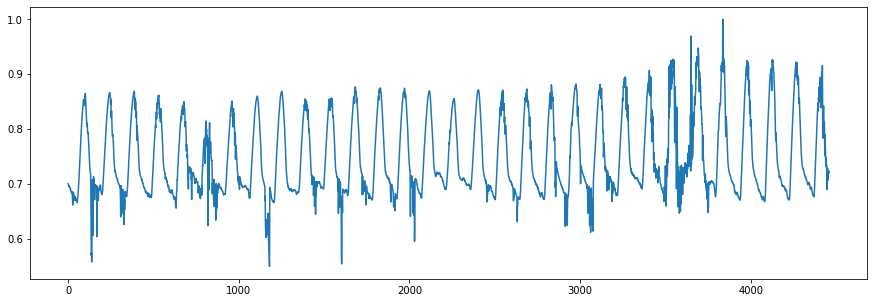

In [69]:
from pandas import read_csv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

# Prepare the input X and target Y
def get_XY(time_series, time_steps):
    #Creating a vector of indices of the steps
    Y_ind = np.arange(time_steps, len(time_series), time_steps) 
    #Taking the values of `time_series` of the `time_steps` indices
    Y = time_series[Y_ind]
    #Defining how many steps was take inside the `time_series`
    rows_x = len(Y)
    #Takeing the 
    X = time_series[range(time_steps*rows_x)]
    X = np.reshape(X, (rows_x, time_steps, 1))    
    return X, Y
 
# constants
url = 'https://raw.githubusercontent.com/tkorting/remote-sensing-images/master/id_756_time_series.csv'
# url = 'https://raw.githubusercontent.com/tkorting/remote-sensing-images/master/id_703_time_series.csv'
split_percent = 0.3
time_steps = 24 # 12 corresponds to 2h of observations
hidden_units = 10
dense_units = 1
activation = 'tanh'

# load full data and
# divide into train/test
data_frame = read_csv(url, usecols=[1]) #, engine='python')
data = np.array(data_frame.values.astype('float32')).flatten()
data = data / data.max() #normaling
N = len(data)
split = int(N * split_percent)
train_data = data[0: split]
test_data = data[split:]

# create X -> y for training and for testing
X_train, y_train = get_XY(train_data, time_steps)
X_test, y_test = get_XY(test_data, time_steps)

# plot original data to check time-series
plt.figure(figsize=(15, 5))
#plt.plot(data_frame/data_frame.max(), label = 'original data',linestyle='--');
plt.plot(data, label = 'original data');

In [70]:
np.shape(X_test)
X_test

array([[[0.6818625 ],
        [0.6813754 ],
        [0.68322617],
        ...,
        [0.7167348 ],
        [0.7218001 ],
        [0.728911  ]],

       [[0.73514515],
        [0.7414767 ],
        [0.7480031 ],
        ...,
        [0.8405416 ],
        [0.84453535],
        [0.8417105 ]],

       [[0.842782  ],
        [0.8438535 ],
        [0.8550555 ],
        ...,
        [0.82028055],
        [0.8156049 ],
        [0.8103448 ]],

       ...,

       [[0.79320085],
        [0.8023573 ],
        [0.81015   ],
        ...,
        [0.8751218 ],
        [0.89450616],
        [0.86304307]],

       [[0.83898306],
        [0.8606078 ],
        [0.86080265],
        ...,
        [0.81385154],
        [0.8120982 ],
        [0.7836548 ]],

       [[0.751315  ],
        [0.7827781 ],
        [0.78959674],
        ...,
        [0.7240405 ],
        [0.7221897 ],
        [0.72335863]]], dtype=float32)

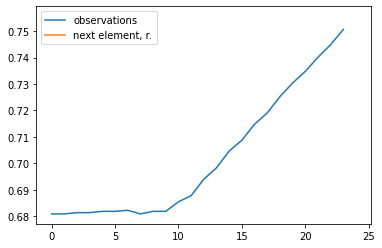

In [3]:
# this is an example of how the training set is created
# given the 'blue curve', predict the 'red dot'
index = 38
plt.plot(X_train[index], label='observations')
plt.plot(time_steps, y_train[index], label='next element, r.')
plt.legend();

Now, we define a SimpleRNN model.

In [ ]:
# create the SimpleRNN model
model = Sequential()
model.add(SimpleRNN(hidden_units, input_shape = (time_steps, 1), activation = activation))
model.add(Dense(units = dense_units, activation = activation))
model.compile(loss='mean_squared_error', optimizer='adam')

# train the model
epochs = 30
history = model.fit(
  X_train, y_train,
  epochs = epochs,
  batch_size = 1,
  validation_data = (X_test, y_test)
)

## Using a LSTM arquitecture

In [75]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten

# #STARDT MODEL
model = Sequential()
model.add(SimpleRNN(hidden_units, input_shape = (time_steps, 1), activation = activation))
model.add(Dense(units = dense_units, activation = activation))
model.compile(loss='mean_squared_error', optimizer='adam')

# fit model
epochs = 30
history = model.fit(
  X_train, y_train,
  epochs = epochs,
  batch_size = 1,
  validation_data = (X_test, y_test)
)

Epoch 1/30
55/55 [==============================] - 1s 12ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 2/30
55/55 [==============================] - 1s 10ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 3/30
55/55 [==============================] - 0s 8ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 4/30
55/55 [==============================] - 1s 10ms/step - loss: 9.3733e-04 - val_loss: 0.0011
Epoch 5/30
55/55 [==============================] - 1s 10ms/step - loss: 8.1217e-04 - val_loss: 9.5043e-04
Epoch 6/30
55/55 [==============================] - 0s 8ms/step - loss: 7.4608e-04 - val_loss: 8.1968e-04
Epoch 7/30
55/55 [==============================] - 0s 8ms/step - loss: 5.5786e-04 - val_loss: 7.3921e-04
Epoch 8/30
55/55 [==============================] - 1s 10ms/step - loss: 4.6855e-04 - val_loss: 7.2100e-04
Epoch 9/30
55/55 [==============================] - 1s 9ms/step - loss: 5.4536e-04 - val_loss: 0.0011
Epoch 10/30
55/55 [==============================] - 1s 10ms/step - loss:

In [73]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 10)            480       
                                                                 
 lstm_1 (LSTM)               (None, 10)                840       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


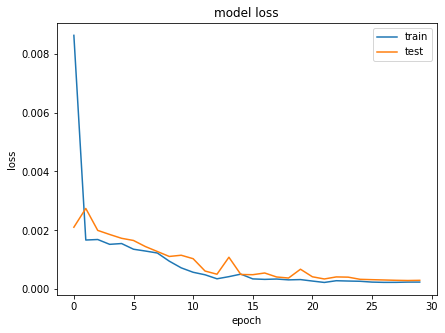

In [6]:
plt.figure(figsize=(15,5))

# plt.subplot(121)
# plt.plot(history.history['accuracy'], label = 'train')
# # plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(loc='upper left')

plt.subplot(122)
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

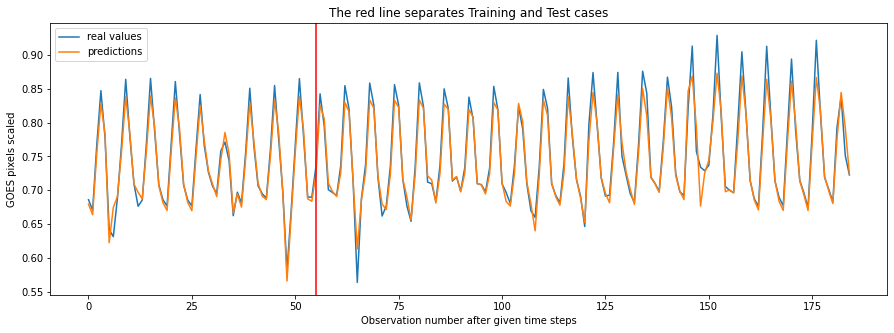

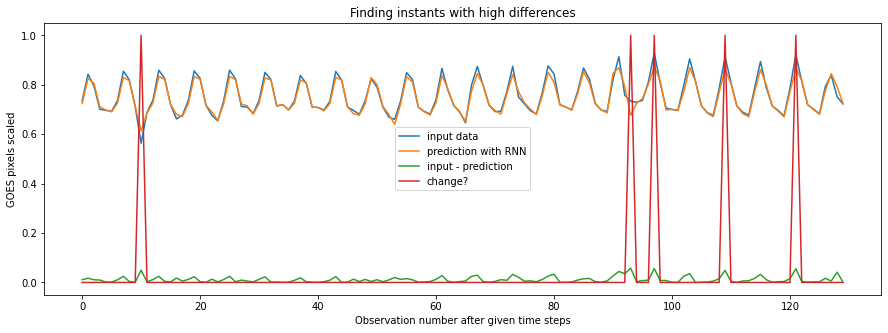

In [7]:
# make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

all_data = np.append(y_train, y_test)
predictions = np.append(train_predict, test_predict)

# plot the results
plt.figure(figsize=(15, 5))
plt.plot(all_data, label = 'real values')
plt.plot(predictions, label = 'predictions') 
plt.axvline(x = len(y_train), color='r')
plt.legend()
plt.xlabel('Observation number after given time steps')
plt.ylabel('GOES pixels scaled')
plt.title('The red line separates Training and Test cases')

difference = np.abs(y_test - test_predict.flatten())
change_threshold = difference.max() * 0.8

plt.figure(figsize=(15, 5))
plt.plot(y_test, label = 'input data')
plt.plot(test_predict.flatten(), label = 'prediction with RNN')
plt.plot(difference, label = 'input - prediction')
plt.plot(difference > change_threshold, label = 'change?')
plt.legend()
plt.xlabel('Observation number after given time steps')
plt.ylabel('GOES pixels scaled')
plt.title('Finding instants with high differences');

## The Vanishing Gradient Problem
---

> *This section is based on [graves2012].*

Standard RNNs only access contextual information in one direction (typically from the past). 

Computing the gradient of loss when applying back-propagation involves updating weights. In some cases the influence of a given input on the hidden layer decays (or blows up) exponentially as it cycles around the network's reccurrent connections.

$h^{(t)} = g^{(t)} (x^{(t)}, x^{(t-1)}, x^{(t-2)}, \dots x^{(2)}, x^{(1)})$

Considering back-propagation at time $t$, the weights with respect to $x^{(1)}$, for example, were updated around $t$ times (producing the *vanish* effect).

<img src="https://raw.githubusercontent.com/tkorting/remote-sensing-images/master/vanishing_gradient_problem.png" width=500>

> The sensitivity to the inputs decays over time as new inputs overwrite the activations of the hidden layer. In result, the network will *forget* the first inputs.




# Long Short-Term Memory (LSTM) networks
---

> *This section is based on [goodfellow2016], which refers to [hochreiter1997]:*

<img src="https://raw.githubusercontent.com/tkorting/remote-sensing-images/master/lstm_original_paper.png" width=500>

The LSTM architecture consists of a set of connected subnets, known as memory blocks, with a chain-like structure. The LSTM was conceived to tackle the Vanishing Gradient Problem, and has been shown capable of storing and acessing information over very long timespans:

<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png" width=500>

> *The following figures are based on [colah2015].*

The cell state $C^{(t)}$ is used to flow the information along the network:

<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-C-line.png" width=500>

Each block is composed by self-connected memory cells, and 3 multiplicative units, called *gates*:

* **forget gate**: this gate multiplies the cell's previous state. The gate activation function is usually the logistic sigmoid, so that the activations are between 0 (*the gate is closed*) and 1 (*the gate is open*).
  
  <img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-f.png" width=500>
  
  $f^{(t)} = \sigma \Big ( W_f h^{(t-1)} + U_f x^{(t)} + b_f \Big )$

* **input gate**: as long as the input gate remains closed (with activation ~ 0), the activation of the cell will not be overwritten by the new inputs arriving in the network

  $i^{(t)} = \sigma \Big ( W_i h^{(t-1)} + U_i x^{(t)} + b_i \Big )$

  according to the value of input gate, the candidate values $\tilde{C}^{(t)}$ will be generated (see the $\times$ operation)

  $\tilde{C}^{(t)} = \tanh \Big ( W_C h^{(t-1)} + U_C x^{(t)} + b_C \Big )$

  <img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-C.png" width=500>

  $C^{(t)} = f^{(t)} \times C^{(t-1)} + i^{(t)} \times \tilde{C}^{(t)}$

* **output gate**: the activation can be made available to the net much later in the sequence, by opening the output gate

  <img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-o.png" width=500>

   $o^{(t)} = \sigma \Big ( W_o h^{(t-1)} + U_o x^{(t)} + b_o \Big )$

   $h^{(t)} = o^{(t)} \times \tanh(C^{(t)})$

> The gate activation function $f$ is usually the logistic sigmoid, so that the activations are between 0 (*gate closed*) and 1 (*gate open*).

> The input and output activation functions ($i$ and $h$) are usually Hyperbolic tangent.


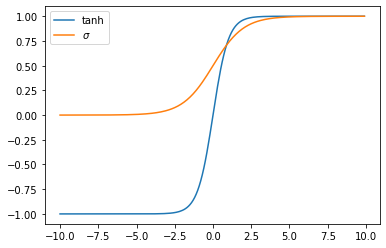

In [71]:
input_vector = np.arange(-10, 10, 0.1)
plt.plot(input_vector, tf.tanh(input_vector), label='tanh')
plt.plot(input_vector, tf.sigmoid(input_vector), label='$\sigma$')
plt.legend();

<img src="https://raw.githubusercontent.com/tkorting/remote-sensing-images/master/lstm_gates_in_action.png" width=500>

> The black nodes are maximally sensitive, the white nodes are entirely insensitive. 

> Gates are below (input), left (forget) and above (output) the hidden layer. 

> $\bigcirc$ means open, and $-$ means a closed gate.

# Exercise 1
---

Create a classification model using the LSTM architecture to deal with the same problem from our previous test (given a GOES time series, with training elements ```time_steps```, *predict* the next element in the time series). When the predicted value is considered different (define a threshold) from the actual value, indicate a candidate disturbance point. 

For *training*, use the entire curve available at https://raw.githubusercontent.com/tkorting/remote-sensing-images/master/id_756_time_series.csv 

For *testing*, use the second one, available at https://raw.githubusercontent.com/tkorting/remote-sensing-images/master/id_703_time_series.csv

# Building a LSMT model

In [76]:
# LSTM MODEL
model = Sequential()
model.add(LSTM(hidden_units, activation=activation, return_sequences=True, input_shape = (time_steps, 1)))
model.add(LSTM(hidden_units, activation=activation))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')#,metrics=['accuracy'])
# fit model
epochs = 30
history = model.fit(
  X_train, y_train,
  epochs = epochs,
  batch_size = 1,
  validation_data = (X_test, y_test)
)

Epoch 1/30
55/55 [==============================] - 5s 35ms/step - loss: 0.2339 - val_loss: 0.0040
Epoch 2/30
55/55 [==============================] - 1s 19ms/step - loss: 0.0028 - val_loss: 0.0032
Epoch 3/30
55/55 [==============================] - 1s 19ms/step - loss: 0.0029 - val_loss: 0.0031
Epoch 4/30
55/55 [==============================] - 1s 20ms/step - loss: 0.0028 - val_loss: 0.0031
Epoch 5/30
55/55 [==============================] - 1s 19ms/step - loss: 0.0028 - val_loss: 0.0031
Epoch 6/30
55/55 [==============================] - 1s 19ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 7/30
55/55 [==============================] - 1s 19ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 8/30
55/55 [==============================] - 1s 19ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 9/30
55/55 [==============================] - 1s 19ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 10/30
55/55 [==============================] - 1s 19ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 11/

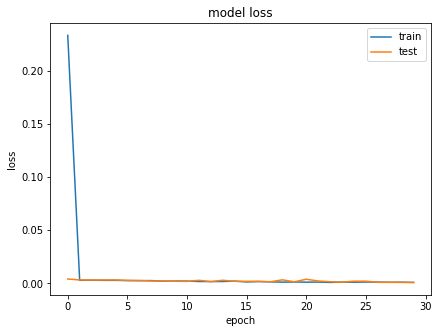

In [77]:
plt.figure(figsize=(15,5))

# plt.subplot(121)
# plt.plot(history.history['accuracy'], label = 'train')
# # plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(loc='upper left')

plt.subplot(122)
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

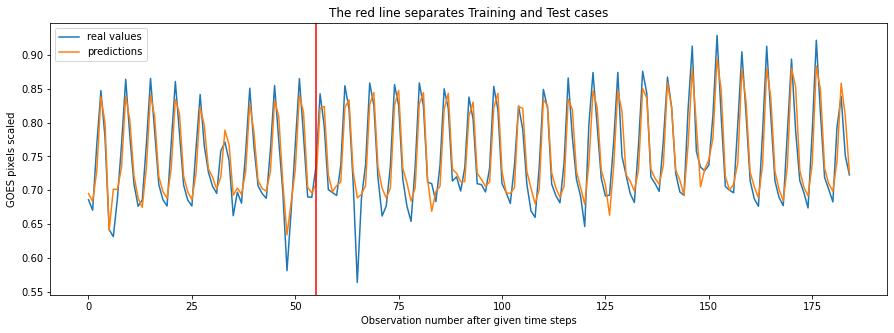

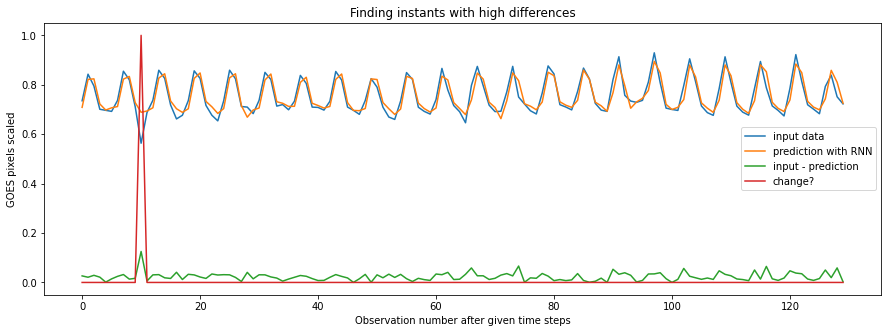

In [78]:
# make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

all_data = np.append(y_train, y_test)
predictions = np.append(train_predict, test_predict)

# plot the results
plt.figure(figsize=(15, 5))
plt.plot(all_data, label = 'real values')
plt.plot(predictions, label = 'predictions') 
plt.axvline(x = len(y_train), color='r')
plt.legend()
plt.xlabel('Observation number after given time steps')
plt.ylabel('GOES pixels scaled')
plt.title('The red line separates Training and Test cases')

difference = np.abs(y_test - test_predict.flatten())
change_threshold = difference.max() * 0.8

plt.figure(figsize=(15, 5))
plt.plot(y_test, label = 'input data')
plt.plot(test_predict.flatten(), label = 'prediction with RNN')
plt.plot(difference, label = 'input - prediction')
plt.plot(difference > change_threshold, label = 'change?')
plt.legend()
plt.xlabel('Observation number after given time steps')
plt.ylabel('GOES pixels scaled')
plt.title('Finding instants with high differences');

# References

[graham1990] **Concrete Mathematics**. Ronald Graham, Donald Knuth, Oren Patashnik.

[chollet2018] **Deep Learning with Phyton**. François Chollet. https://livebook.manning.com/book/deep-learning-with-python/

[goodfellow2016] **The Deep Learning Book**. Ian Goodfellow, Yoshua Bengio, Aaron Courville. https://www.deeplearningbook.org/

[graves2012] **Supervised Sequence Labelling with Recurrent Neural Networks**. Alex Graves. 

[simplernn2021] **Understanding Simple Recurrent Neural Networks In Keras**. https://machinelearningmastery.com/start-here/

[karpathy2015] **The Unreasonable Effectiveness of Recurrent Neural Networks**. https://karpathy.github.io/2015/05/21/rnn-effectiveness/

[hochreiter1997] **Long Short-Term Memory**, Sepp Hochreiter, Jurgen Schmidhuber. http://www.bioinf.jku.at/publications/older/2604.pdf

[rumelhart1986] **Learning representations byback-propagating error**. David Rumelhart, Geoffrey Hinton, Ronald Williams. http://www.cs.toronto.edu/~hinton/absps/naturebp.pdf

[colah2015] **Understanding LSTM Networks**. http://colah.github.io/posts/2015-08-Understanding-LSTMs/